In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
import ast
import os

from tqdm import tqdm


In [2]:
#extracting just the CVC labels
train_data = pd.read_csv("/kaggle/input/ranzcr-clip-catheter-line-classification/train.csv")
train_data = train_data[train_data['NGT - Borderline'] != 1]
train_data['NGT - Present'] = np.where((train_data['NGT - Abnormal'] == 0) & (train_data['NGT - Normal'] == 0) & (train_data['NGT - Borderline'] == 0), 0, 1)

train_data['NGT - Present'].value_counts()

NGT - Present
0    24501
1     5053
Name: count, dtype: int64

In [3]:
sampled_data = pd.concat([train_data[train_data['NGT - Present'] == 1].sample(n=750), train_data[train_data['NGT - Present'] == 0].sample(n=750)])
sampled_data

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,NGT - Present
2381,1.2.826.0.1.3680043.8.498.72027842236740426828...,0,0,1,0,0,0,1,0,0,1,0,fd3ab6f0e,1
21218,1.2.826.0.1.3680043.8.498.17124285924673288354...,0,1,0,0,0,0,1,0,1,0,0,2bb41c720,1
9458,1.2.826.0.1.3680043.8.498.83787296854153893198...,0,0,1,0,0,0,1,0,1,0,0,05029c63a,1
4115,1.2.826.0.1.3680043.8.498.87430326611380193974...,0,0,1,0,0,0,1,0,1,0,0,a54516ab5,1
27341,1.2.826.0.1.3680043.8.498.11939772432256969564...,0,1,0,0,0,0,1,0,0,1,0,9cd0c75bb,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29678,1.2.826.0.1.3680043.8.498.90915831742574604863...,0,0,0,0,0,0,0,0,0,1,0,b1f81964b,0
29690,1.2.826.0.1.3680043.8.498.92686998100433418697...,0,0,1,0,0,0,0,0,1,0,0,fe900cd30,0
3397,1.2.826.0.1.3680043.8.498.11438096043898267210...,0,0,0,0,0,0,0,0,0,1,0,fbb620657,0
7600,1.2.826.0.1.3680043.8.498.95329529106960247096...,0,0,0,0,0,0,0,0,0,1,0,547d5c00b,0


In [4]:
studyInstance = sampled_data['StudyInstanceUID'].tolist()
studyInstance

for i in range(len(studyInstance)):
    studyInstance[i] = f'{studyInstance[i]}.jpg'
    
studyInstance   

['1.2.826.0.1.3680043.8.498.72027842236740426828450197490947975428.jpg',
 '1.2.826.0.1.3680043.8.498.17124285924673288354603519153366166318.jpg',
 '1.2.826.0.1.3680043.8.498.83787296854153893198021375584075109904.jpg',
 '1.2.826.0.1.3680043.8.498.87430326611380193974662642793143433568.jpg',
 '1.2.826.0.1.3680043.8.498.11939772432256969564077532046371198564.jpg',
 '1.2.826.0.1.3680043.8.498.44820679417635582340602856104412843092.jpg',
 '1.2.826.0.1.3680043.8.498.11151413709327750697141242070265662852.jpg',
 '1.2.826.0.1.3680043.8.498.85042569865520881877173875324351728516.jpg',
 '1.2.826.0.1.3680043.8.498.27474037990075738604723665323633255657.jpg',
 '1.2.826.0.1.3680043.8.498.12149340551138111408992017658320866089.jpg',
 '1.2.826.0.1.3680043.8.498.73791192760623124558588910285324144987.jpg',
 '1.2.826.0.1.3680043.8.498.56963821502031677494242406311740794707.jpg',
 '1.2.826.0.1.3680043.8.498.39089139069434104421398114299634612649.jpg',
 '1.2.826.0.1.3680043.8.498.19291620124580842212309

In [5]:
def processImages(filenames,train_test):

    imgs = []
    FileIDs = []
    lst = []


    desired_channels = 3

    count = 0
    for file in tqdm(filenames, position=0, leave=True):
        # Making sure the images are the same pixel size
        img = Image.open(f"/kaggle/input/ranzcr-clip-catheter-line-classification/{train_test}/{file}")
        img = img.resize((300, 300))
        img = np.array(img)

        # Ensure that the image has 3 channels (RGB)
        if img.shape[-1] != 3:
            img = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB by duplicating channels

        imgs.append(img)  # Append the 4D image to the list

        # Save filename for later
        FileIDs.append(file)

        count += 1

    # Convert the list of images to a numpy array
    imgs = np.array(imgs)
    return imgs, FileIDs

In [6]:
train_imgs, fileIDs = processImages(studyInstance, 'train')

100%|██████████| 1500/1500 [01:07<00:00, 22.09it/s]


In [7]:
#cleaning up the labels
UID = []
for i in range(len(fileIDs)):
  UID.append(fileIDs[i].replace(".jpg",""))

UID[0:10]

['1.2.826.0.1.3680043.8.498.72027842236740426828450197490947975428',
 '1.2.826.0.1.3680043.8.498.17124285924673288354603519153366166318',
 '1.2.826.0.1.3680043.8.498.83787296854153893198021375584075109904',
 '1.2.826.0.1.3680043.8.498.87430326611380193974662642793143433568',
 '1.2.826.0.1.3680043.8.498.11939772432256969564077532046371198564',
 '1.2.826.0.1.3680043.8.498.44820679417635582340602856104412843092',
 '1.2.826.0.1.3680043.8.498.11151413709327750697141242070265662852',
 '1.2.826.0.1.3680043.8.498.85042569865520881877173875324351728516',
 '1.2.826.0.1.3680043.8.498.27474037990075738604723665323633255657',
 '1.2.826.0.1.3680043.8.498.12149340551138111408992017658320866089']

In [8]:
columns_to_drop = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Normal',
                  "NGT - Incompletely Imaged", "Swan Ganz Catheter Present", "PatientID", "CVC - Borderline", 'CVC - Abnormal', 'CVC - Normal']

CVCsampled_data = sampled_data.drop(columns=columns_to_drop, axis=1)

CVCsampled_data.set_index('StudyInstanceUID', inplace=True)

In [9]:
CVCsampled_data = CVCsampled_data.reindex(UID)


In [10]:
train_labels = np.empty((0,3))
data = []

for ID in UID:
    data.append(CVCsampled_data.loc[ID])

train_labels_df = pd.DataFrame(data)



train_labels_df = train_labels_df.reindex(UID)
train_labels = train_labels_df['NGT - Present'].values
# train_labels = train_labels_df.values
train_labels

array([1, 1, 1, ..., 0, 0, 0])

In [11]:
from sklearn.model_selection import train_test_split

# Split your data into training and temporary data (combined validation and test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(train_imgs, train_labels, test_size=0.3, random_state=42)

# Split the temporary data into validation and test sets
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, random_state=42)

In [12]:
print(len(train_labels))
print(len(train_imgs))


1050
1050


In [13]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization
# Load the DenseNet121 base model without its top layers
base_model = DenseNet121(weights='imagenet', include_top=False)

# Add dropout and batch normalization to custom fully connected layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)


D1019 06:58:44.395660674      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1019 06:58:44.395685658      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1019 06:58:44.395689062      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1019 06:58:44.395691555      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1019 06:58:44.395693788      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1019 06:58:44.395696331      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1019 06:58:44.395699749      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1019 06:58:44.

29084464/29084464 [==============================] - 0s 0us/step


In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


# Compile the model with optimizer and loss function
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the best model during training
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Model Training with callbacks
history = model.fit(train_imgs, train_labels, epochs=30, validation_data=(val_imgs, val_labels), callbacks=[reduce_lr, early_stop, model_checkpoint])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_imgs, test_labels)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/30
33/33 [==============================] - 242s 7s/step - loss: 0.6585 - accuracy: 0.7000 - val_loss: 0.5851 - val_accuracy: 0.7289 - lr: 0.0100
Epoch 2/30
33/33 [==============================] - 219s 7s/step - loss: 0.4641 - accuracy: 0.8133 - val_loss: 0.4836 - val_accuracy: 0.8044 - lr: 0.0100
Epoch 3/30
33/33 [==============================] - 220s 7s/step - loss: 0.3136 - accuracy: 0.8705 - val_loss: 0.5736 - val_accuracy: 0.7111 - lr: 0.0100
Epoch 4/30
33/33 [==============================] - 217s 7s/step - loss: 0.1800 - accuracy: 0.9286 - val_loss: 0.5125 - val_accuracy: 0.8089 - lr: 0.0100
Epoch 5/30
33/33 [==============================] - 218s 7s/step - loss: 0.0995 - accuracy: 0.9581 - val_loss: 0.4295 - val_accuracy: 0.8222 - lr: 0.0100
Epoch 6/30
33/33 [==============================] - 219s 7s/step - loss: 0.0711 - accuracy: 0.9781 - val_loss: 0.5158 - val_accuracy: 0.8356 - lr: 0.0100
Epoch 7/30
33/33 [==============================] - 216s 7s/step - loss: 0.0

In [41]:
def buildTrainData(catheter, train_data, size):
    
    train_data = train_data[train_data[f'{catheter} - Present'] == 1]
    train_data = train_data = train_data[~((train_data[f'{catheter} - Normal'] == 1) & (train_data[f'{catheter} - Abnormal'] == 1))]
    train_data[f'{catheter} - Normal/Abnormal'] = np.where(train_data[f'{catheter} - Normal'] == 1, 1, 0)
    sampled_data = pd.concat([train_data[train_data[f'{catheter} - Normal'] == 1].sample(n=size), train_data[train_data[f'{catheter} - Abnormal'] == 1].sample(n=size)])
    
    return sampled_data

In [42]:
sample = buildTrainData('NGT', train_data, 250)
sample[['NGT - Normal', 'NGT - Abnormal']].value_counts()


NGT - Normal  NGT - Abnormal
0             1                 250
1             0                 250
Name: count, dtype: int64

In [43]:
nAb_data = getFileNames(sample)

ngt_imgs, fileIDs = processImages(nAb_data, 'train')

100%|██████████| 500/500 [00:19<00:00, 26.20it/s]


In [49]:
UID = []
for i in range(len(fileIDs)):
  UID.append(fileIDs[i].replace(".jpg",""))


columns_to_drop = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Normal',
                  "NGT - Incompletely Imaged", "Swan Ganz Catheter Present", "PatientID", "CVC - Borderline", 'CVC - Abnormal', 'CVC - Normal', 'NGT - Present']

NGTsample = sample.drop(columns=columns_to_drop, axis=1)

NGTsample.set_index('StudyInstanceUID', inplace=True)

NGTsample


,NGT - Normal/Abnormal
StudyInstanceUID,
1.2.826.0.1.3680043.8.498.83557702852578344152590975521603931676,1
1.2.826.0.1.3680043.8.498.33475188387649615865841783605310668224,1
1.2.826.0.1.3680043.8.498.75705881484822777811302505593938591112,1
1.2.826.0.1.3680043.8.498.82830037186816678378898651543905905890,1
1.2.826.0.1.3680043.8.498.12422333356367561670298118556489412076,1
...,...
1.2.826.0.1.3680043.8.498.77213305346319900514294160115528863198,0
1.2.826.0.1.3680043.8.498.12707801410845250972678487173558836809,0
1.2.826.0.1.3680043.8.498.64848197645682080966935746451622376111,0


In [50]:
# Extract UIDs from fileIDs
UID = [fileID.replace(".jpg", "") for fileID in fileIDs]

# List of columns to drop
columns_to_drop = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Normal',
                  "NGT - Incompletely Imaged", "Swan Ganz Catheter Present", "PatientID", "CVC - Borderline", 
                  'CVC - Abnormal', 'CVC - Normal', 'CVC - Present']

# Drop the columns and set index
NGTsample = sample.drop(columns=columns_to_drop, errors='ignore')  # 'errors' parameter set to 'ignore' to avoid KeyError
NGTsample.set_index('StudyInstanceUID', inplace=True)

NGTsample



,NGT - Present,NGT - Normal/Abnormal
StudyInstanceUID,,
1.2.826.0.1.3680043.8.498.83557702852578344152590975521603931676,1,1
1.2.826.0.1.3680043.8.498.33475188387649615865841783605310668224,1,1
1.2.826.0.1.3680043.8.498.75705881484822777811302505593938591112,1,1
1.2.826.0.1.3680043.8.498.82830037186816678378898651543905905890,1,1
1.2.826.0.1.3680043.8.498.12422333356367561670298118556489412076,1,1
...,...,...
1.2.826.0.1.3680043.8.498.77213305346319900514294160115528863198,1,0
1.2.826.0.1.3680043.8.498.12707801410845250972678487173558836809,1,0
1.2.826.0.1.3680043.8.498.64848197645682080966935746451622376111,1,0


In [51]:
train_labels_df = np.empty((0,3))
data = []

for ID in UID:
    data.append(NGTsample.loc[ID])

train_labels_df = pd.DataFrame(data)



train_labels_df = train_labels_df.reindex(UID)
ngt_labels = train_labels_df['NGT - Normal/Abnormal'].values
# train_labels = train_labels_df.values
ngt_labels


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [52]:
from sklearn.model_selection import train_test_split

# Split your data into training and temporary data (combined validation and test)
trainNGT_imgs, temp_imgs, trainNGT_labels, temp_labels = train_test_split(ngt_imgs, ngt_labels, test_size=0.2, random_state=42)

# Split the temporary data into validation and test sets
valNGT_imgs, testNGT_imgs, valNGT_labels, testNGT_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, random_state=42)

In [55]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
base_model = DenseNet121(weights='imagenet', include_top=False)


# Add dropout and batch normalization to custom fully connected layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


# Compile the model with optimizer and loss function
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the best model during training
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Model Training with callbacks
history = model.fit(trainNGT_imgs, trainNGT_labels, epochs=30, validation_data=(val_imgs, val_labels), callbacks=[reduce_lr, early_stop, model_checkpoint])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_imgs, test_labels)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/30
13/13 [==============================] - 106s 7s/step - loss: 0.8169 - accuracy: 0.6050 - val_loss: 0.7350 - val_accuracy: 0.4844 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - 87s 7s/step - loss: 0.6494 - accuracy: 0.6725 - val_loss: 0.6992 - val_accuracy: 0.4800 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - 88s 7s/step - loss: 0.4995 - accuracy: 0.7775 - val_loss: 0.7756 - val_accuracy: 0.4667 - lr: 0.0100
Epoch 4/30
13/13 [==============================] - 89s 7s/step - loss: 0.2937 - accuracy: 0.8875 - val_loss: 0.6905 - val_accuracy: 0.5422 - lr: 0.0100
Epoch 5/30
13/13 [==============================] - 87s 7s/step - loss: 0.2128 - accuracy: 0.9225 - val_loss: 0.6453 - val_accuracy: 0.6089 - lr: 0.0100
Epoch 6/30
13/13 [==============================] - 86s 7s/step - loss: 0.0854 - accuracy: 0.9675 - val_loss: 0.6639 - val_accuracy: 0.5778 - lr: 0.0100
Epoch 7/30
13/13 [==============================] - 88s 7s/step - loss: 0.0450 - 

In [59]:
pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


8/8 [==============================] - 10s 961ms/step


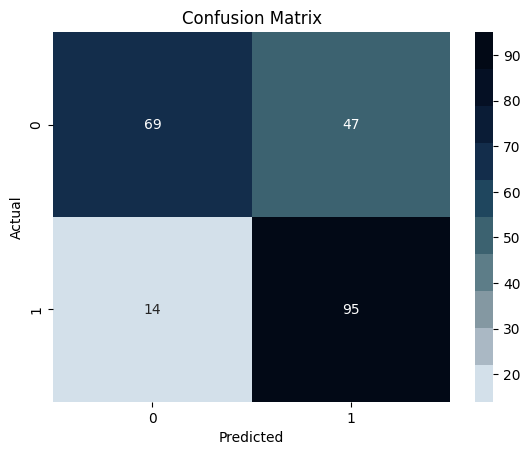

In [60]:


import seaborn as sns

# Make predictions
predictions = model.predict(test_imgs)

# Convert the predictions to a binary array
predictions_binary = np.where(predictions > 0.5, 1, 0)


from sklearn.metrics import confusion_matrix

# Create the confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions_binary)

plt.gca().patch.set_facecolor('none')



custom_palette = ['#D3E0EA', '#AAB8C4', '#8498A2', '#5D7D88', '#3C6270', 
                  '#1F465E', '#132D4B', '#0A1C36', '#051024', '#020916']

# Create a heatmap plot of the confusion matrix
sns.heatmap(confusion_matrix, annot=True, cmap=custom_palette)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

D1019 09:10:36.425302730      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1019 09:10:36.425347332      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1019 09:10:36.425351241      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1019 09:10:36.425353899      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1019 09:10:36.425356218      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1019 09:10:36.425358631      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1019 09:10:36.425360897      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1019 09:10:36.

NameError: name 'model' is not defined